In [1]:
%cd "/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database"
! ls

/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database
 COVID		       NORMAL.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 COVID.metadata.xlsx   README.md.txt
 NORMAL		      'Viral Pneumonia'


In [2]:
! mkdir /kaggle/working/my_classes
! cp -r NORMAL COVID 'Viral Pneumonia' /kaggle/working/my_classes # move normal, covid, pneumonia folders into my classes folder

In [3]:
! ls /kaggle/working/my_classes

 COVID	 NORMAL  'Viral Pneumonia'


In [4]:
kaggle_root = "/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database"
dataset_root = "/kaggle/working/my_classes"

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

import torch
import torch.nn as nn

import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

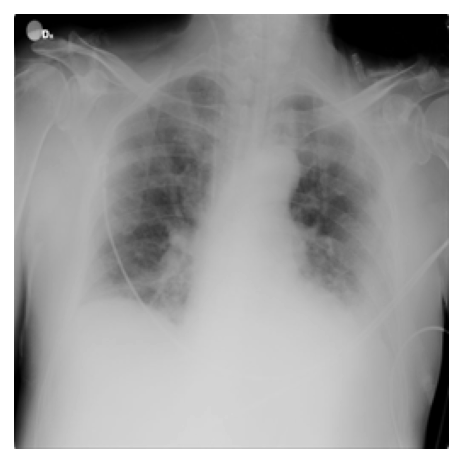

COVID
(256, 256)


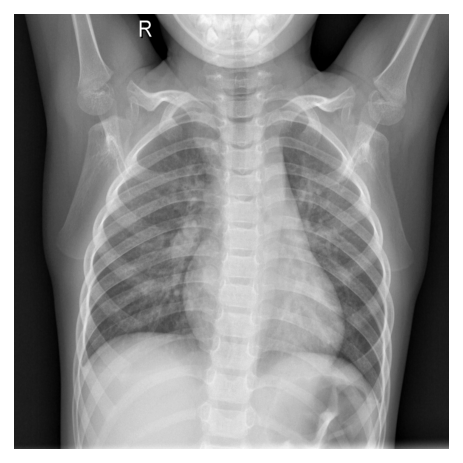

Normal
(1024, 1024)


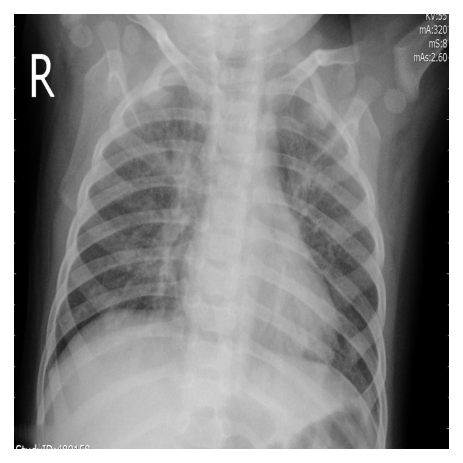

Viral Pneumonia
(1024, 1024)


In [6]:
img1 = cv2.imread(kaggle_root +'/COVID/COVID (1).png',0)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()
print('COVID')
print(img1.shape)
img2 = cv2.imread(kaggle_root +'/NORMAL/NORMAL (1).png',0)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.show()
print('Normal')
print(img2.shape)
img3 = cv2.imread(kaggle_root +'/Viral Pneumonia/Viral Pneumonia (1).png',0)
plt.imshow(img3, cmap='gray')
plt.axis('off')
plt.show()
print('Viral Pneumonia')
print(img3.shape)

In [7]:
transform = transforms.Compose([transforms.Resize((255,255)),transforms.ToTensor()]) #to resize images and transform them to tensors

In [8]:
! pip install split-folders
%cd /kaggle/working
! mkdir output
import splitfolders
# 80% training 10% validation 10% testing
splitfolders.ratio(dataset_root, output="output", seed=1234, ratio=(0.8, 0.1, 0.1), group_prefix=None)


/kaggle/working


Copying files: 3886 files [00:02, 1599.86 files/s]


In [9]:
! ls output

test  train  val


In [10]:
output = "/kaggle/working/output"
train_data = output + '/train'
valid_data = output + '/val'
test_data = output + '/test'


In [11]:
dataset_train = datasets.ImageFolder(train_data, transform=transform) # ImageFolder for each class COVID , Normal , Pneumia
dataset_valid = datasets.ImageFolder(valid_data, transform=transform)
dataset_test = datasets.ImageFolder(test_data, transform=transform)

In [12]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True)

In [13]:
i = 0
for images, labels in dataloader_train:
    print(images.shape)
    print(labels, '\n')
    i += 1
    if i == 2:
        break

torch.Size([32, 3, 255, 255])
tensor([2, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 1, 0, 1, 0, 2, 2, 2, 2, 0, 0, 2,
        2, 1, 0, 1, 2, 1, 1, 2]) 

torch.Size([32, 3, 255, 255])
tensor([1, 1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2, 1,
        1, 1, 2, 2, 1, 0, 2, 2]) 



In [14]:
import torch.optim as optim

def run_model(model,dataloader,valid_loader, optimizer, train = True):
    if train:
        model.train()
    pred=[]
    labels=[]
    loss=nn.CrossEntropyLoss()
    total_loss=0
    total_train = 0
    correct_train = 0
    valid_loss = 0.0
    total_train_val=0.0
    correct_train_val =0.0
    
    for(data,label) in dataloader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        if 'Inception3' in str(type(model)):
            output, aux_output = model(data)
            loss1 = loss(output, label)
            loss2 = loss(aux_output, label)
            loss_ = loss1 + 0.4*loss2
        else:    
            output= model(data)
            loss_=loss(output,label)
        
        
        total_loss+=loss_.item()
        loss_.backward()
        optimizer.step()
        pred+=output.tolist()
        labels+=label.tolist()
        
        # accuracy
        _, predicted = torch.max(output.data, 1)
        total_train += label.nelement() #
        correct_train += predicted.eq(label.data).sum().item()
        accuracy = correct_train / total_train
    
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        data, target = data.cuda(), target.cuda()
        output_valid = model(data)
        loss_v = loss(output_valid, target)
        
        # accuracy validation 
        _, predicted = torch.max(output_valid.data, 1)
        total_train_val += target.nelement() #
        correct_train_val += predicted.eq(target.data).sum().item()
        accuracy_val = correct_train_val / total_train_val
        
        # update-average-validation-loss 
        valid_loss += loss_v.item()


    return labels,pred,total_loss/len(dataloader),accuracy,accuracy_val,valid_loss/len(valid_loader),model


In [15]:
def test_model(model,dataloader):
    # test-the-model
    predictions1 =[]
    labels1=[]
    model.eval()  # it-disables-dropout
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataloader:
            
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()          
            
            
            labels1.append(labels.item())
            predictions1.append(predicted.item())
        labels1 = np.array(labels1)
        predictions1 = np.array(predictions1)
        f1_pred = f1_score(labels1, predictions1, average='weighted')
        print("F1 score (weighted): {:.3f}" .format(f1_pred))
        print('Testing Accuracy: {:.3f} %' .format(100*(correct / total)))  

In [17]:
class ConModel_few(nn.Module):
    def __init__(self):
        super(ConModel_few, self).__init__()  #inheriting functionality of nn module
        self.conv1 = nn.Conv2d(3, 32,3, 1)  #defining layers  
        self.dropout1= nn.Dropout(0.25)
        self.fc1 = nn.Linear(508032, 84)
        self.fc2 = nn.Linear(84, 3)  
        

    def forward(self, x):
        x=self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        #print(x.shape)
        x=self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x) 
        output = F.log_softmax(x,dim=1)
        return output
        

**Data Augementation**

In [19]:
train_transform = transforms.Compose([transforms.Resize((255,255)),transforms.RandomRotation(30),transforms.RandomHorizontalFlip(),transforms.ToTensor()]) #to resize images and transform them to tensors

In [20]:
dataset2_train = datasets.ImageFolder(train_data, transform=train_transform) # ImageFolder for each class COVID , Normal , Pneumia
dataset2_valid = datasets.ImageFolder(valid_data, transform=train_transform)
dataset2_test = datasets.ImageFolder(test_data, transform=train_transform)

In [21]:
trainloader = torch.utils.data.DataLoader(dataset2_train, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(dataset2_valid, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset2_test, batch_size=1, shuffle=True)

In [23]:
cnn_model_few = ConModel_few()
cnn_model_few.to(device)

epoch = 5 #tunable hyperparameter
optimizer = torch.optim.Adam(cnn_model_few.parameters(),0.00001,weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=5,factor=.3,threshold=1e-4)


for e in range(epoch):
    labels , pred, loss, accuracy,accuracy_val ,valid_loss,model=run_model(cnn_model_few,dataloader_train,dataloader_valid,optimizer)
    cnn_model_few= model
    print('Epoch {} for CNN(few), Train Loss: {:.3f}'.format(e+1, loss), 'Train Accuracy: {:.3f}%'.format(100*accuracy),'Validation accuracy: {:.3f}%'.format(100*accuracy_val),'Validation Loss: {:.3f}'.format(valid_loss))
print()
print("test accuracy cnn_model_few layers")
test_model(cnn_model_few,dataloader_test) 
print()

Epoch 1 for CNN(few), Train Loss: 0.644 Train Accuracy: 74.582% Validation accuracy: 80.928% Validation Loss: 0.465
Epoch 2 for CNN(few), Train Loss: 0.412 Train Accuracy: 85.682% Validation accuracy: 89.175% Validation Loss: 0.359
Epoch 3 for CNN(few), Train Loss: 0.334 Train Accuracy: 88.707% Validation accuracy: 87.629% Validation Loss: 0.301
Epoch 4 for CNN(few), Train Loss: 0.305 Train Accuracy: 89.994% Validation accuracy: 89.691% Validation Loss: 0.274
Epoch 5 for CNN(few), Train Loss: 0.266 Train Accuracy: 91.216% Validation accuracy: 90.722% Validation Loss: 0.235

test accuracy cnn_model_few layers
F1 score (weighted): 0.918
Testing Accuracy: 91.795 %

